In [1]:
# 0.1 Create virtual environment (run in terminal)
# python -m venv activity_env
# source activity_env/bin/activate  # macOS/Linux
# activity_env\Scripts\activate     # Windows

# 0.2 Install packages
!pip install numpy pandas scikit-learn matplotlib seaborn joblib tqdm

In [2]:
# 0.3 Import libraries
import os, json, urllib.request, ssl, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

In [3]:
print("""
UCI HAR Dataset: https://archive.ics.uci.edu/dataset/240
- 10 299 samples (2.56 s windows @ 50 Hz)
- 6 activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING
- 128 timesteps per sample, 3-axis accelerometer
""")


UCI HAR Dataset: https://archive.ics.uci.edu/dataset/240
- 10 299 samples (2.56 s windows @ 50 Hz)
- 6 activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING
- 128 timesteps per sample, 3-axis accelerometer



In [ ]:
import os
import urllib.request
import zipfile
from pathlib import Path
import ssl

def download_uci_har(data_dir="data"):
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)

    url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"

    outer_zip = data_dir / "har_raw.zip"
    inner_zip = data_dir / "UCI HAR Dataset.zip"
    final_dir = data_dir / "UCI HAR Dataset"

    ssl._create_default_https_context = ssl._create_unverified_context

    if not outer_zip.exists():
        print(f"⬇ Baixando {url} ...")
        urllib.request.urlretrieve(url, outer_zip)
    else:
        print(f"Já existe: {outer_zip} ({outer_zip.stat().st_size:,} bytes)")

    if not inner_zip.exists():
        print("📦 Extraindo ZIP externo...")
        with zipfile.ZipFile(outer_zip, "r") as z:
            z.extractall(data_dir)

    if not final_dir.exists():
        print("📦 Extraindo 'UCI HAR Dataset.zip'...")
        with zipfile.ZipFile(inner_zip, "r") as z:
            z.extractall(data_dir)

    print(f"🎉 Dataset disponível em: {final_dir}")
    return final_dir

# Uso
data_path = download_uci_har()


⬇ Baixando https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip ...
📦 Extraindo ZIP externo...
📦 Extraindo 'UCI HAR Dataset.zip'...
🎉 Dataset disponível em: data/UCI HAR Dataset


In [5]:
import os
import numpy as np

y_raw = np.loadtxt(os.path.join(data_path, "train", "y_train.txt"))

signals_dir = os.path.join(data_path, "train", "Inertial Signals")

X_x = np.loadtxt(os.path.join(signals_dir, "total_acc_x_train.txt"))
X_y = np.loadtxt(os.path.join(signals_dir, "total_acc_y_train.txt"))
X_z = np.loadtxt(os.path.join(signals_dir, "total_acc_z_train.txt"))


In [6]:
activity_names = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']
unique, counts = np.unique(y_raw, return_counts=True)

for cls, cnt in zip(unique, counts):
    cls_int = int(cls)
    cnt_int = int(cnt)   
    print(f"Class {cls_int}: {activity_names[cls_int-1]:15s} {cnt_int:5d} samples")


Class 1: Walking          1226 samples
Class 2: Upstairs         1073 samples
Class 3: Downstairs        986 samples
Class 4: Sitting          1286 samples
Class 5: Standing         1374 samples
Class 6: Laying           1407 samples


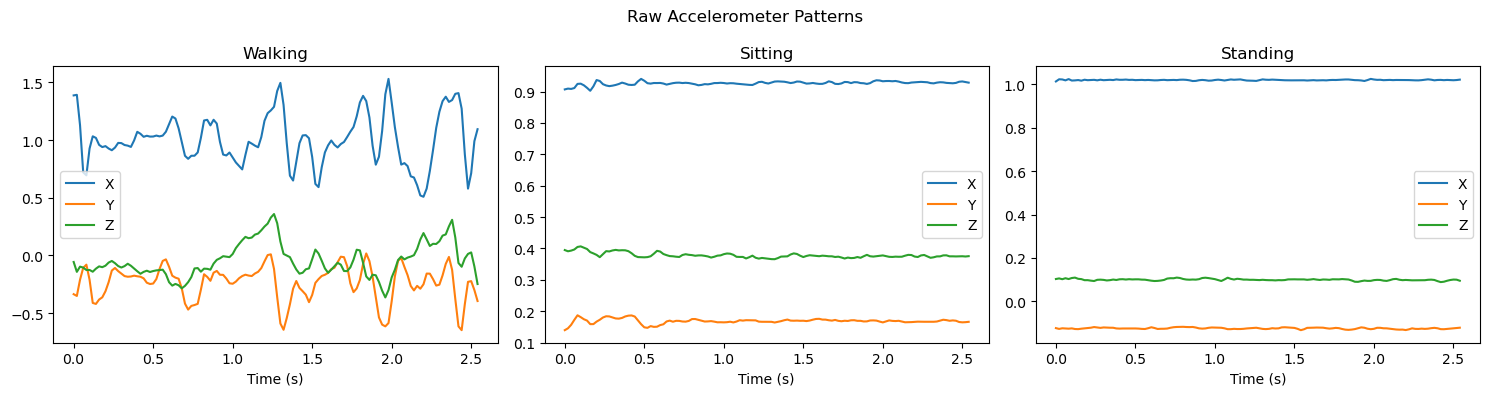

In [7]:
# 2.2 Visualise one window per activity (first 3)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, activity in enumerate([1, 4, 5]):  # Walking, Sitting, Standing
    idx = np.where(y_raw == activity)[0][0]
    t = np.arange(128) / 50.0
    axes[i].plot(t, X_x[idx], label='X')
    axes[i].plot(t, X_y[idx], label='Y')
    axes[i].plot(t, X_z[idx], label='Z')
    axes[i].set_title(activity_names[activity-1])
    axes[i].set_xlabel("Time (s)")
    axes[i].legend()
plt.suptitle("Raw Accelerometer Patterns")
plt.tight_layout()
plt.show()

In [8]:
# 3.1 Keep only Sitting(4), Standing(5), Laying(6)
mask = np.isin(y_raw, [4, 5, 6])
X_x_f, X_y_f, X_z_f, y_f = X_x[mask], X_y[mask], X_z[mask], y_raw[mask]
y_f = y_f - 4  # map 4,5,6 → 0,1,2
class_names = ["Sitting", "Standing", "Laying"]

print(f"Filtered dataset: {len(y_f)} samples")
print("Class distribution:", np.bincount(y_f.astype(int)))

Filtered dataset: 4067 samples
Class distribution: [1286 1374 1407]


In [9]:
# 4.1 Feature extractor - EXACT same logic as Kotlin
def extract_features(X_x, X_y, X_z):

    X = np.stack([X_x, X_y, X_z], axis=-1)  # (n,128,3)
    feats = []
    for i in tqdm(range(X.shape[0]), desc="Extracting"):
        sample = []
        for axis in range(3):
            data = X[i, :, axis]
            sample.extend([np.mean(data), np.std(data), np.min(data), np.max(data)])
        mag = np.sqrt(X[i, :, 0]**2 + X[i, :, 1]**2 + X[i, :, 2]**2)
        sample.extend([np.mean(mag), np.std(mag), np.min(mag), np.max(mag)])
        feats.append(sample)
    return np.array(feats)

X_features = extract_features(X_x_f, X_y_f, X_z_f)
print("Feature matrix shape:", X_features.shape)

Extracting:   0%|          | 0/4067 [00:00<?, ?it/s]

Feature matrix shape: (4067, 16)


In [10]:
# 5.1 Split 80/20 stratified
X_train, X_val, y_train, y_val = train_test_split(
    X_features, y_f, test_size=0.2, random_state=42, stratify=y_f
)
print(f"Train: {X_train.shape[0]}  Val: {X_val.shape[0]}")

Train: 3253  Val: 814


In [11]:
# 5.2 Train with mobile-friendly hyper-parameters
model = DecisionTreeClassifier(
    max_depth=8,          # limit depth for speed
    min_samples_split=20, # prevent overfitting
    random_state=42
)
model.fit(X_train, y_train)
print("Training complete")

Training complete


In [12]:
# 5.3 Evaluate
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print(f"Train accuracy: {train_acc:.2%}")
print(f"Val accuracy: {val_acc:.2%}")

Train accuracy: 96.43%
Val accuracy: 94.47%


In [13]:
# 5.4 Detailed report
print("\nClassification Report (Validation):")
print(classification_report(y_val, model.predict(X_val), target_names=class_names))


Classification Report (Validation):
              precision    recall  f1-score   support

     Sitting       0.90      0.92      0.91       257
    Standing       0.93      0.91      0.92       275
      Laying       1.00      1.00      1.00       282

    accuracy                           0.94       814
   macro avg       0.94      0.94      0.94       814
weighted avg       0.94      0.94      0.94       814



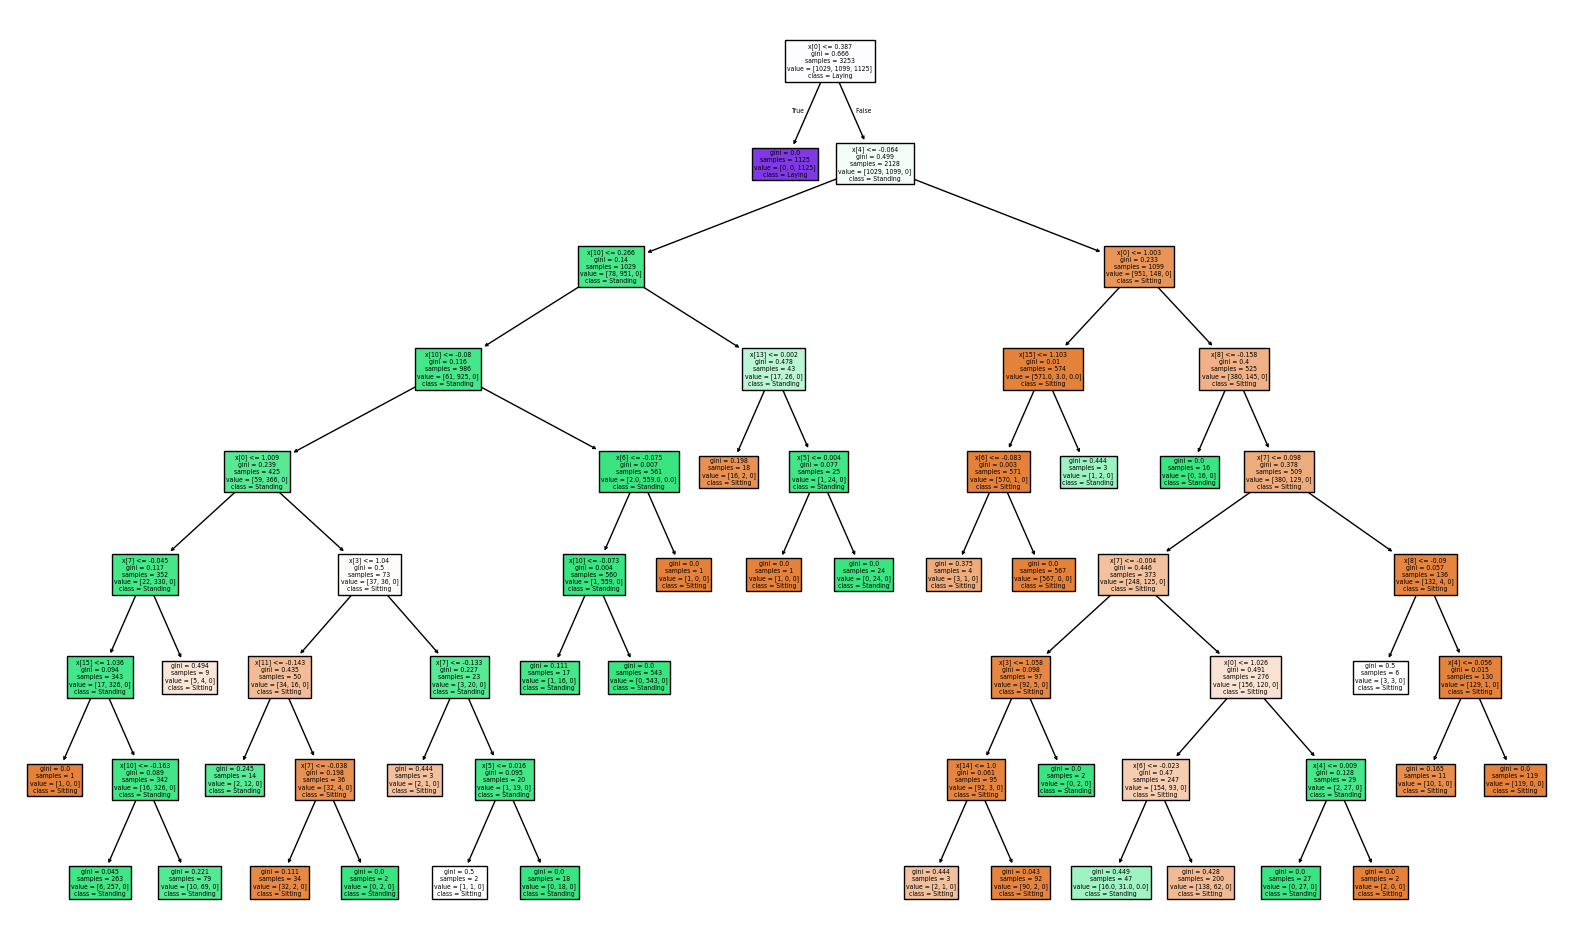

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plot_tree(
    model,
    class_names=class_names,  # você já definiu isso antes
    filled=True
)
plt.savefig("decision_tree.png", dpi=150, bbox_inches="tight")
plt.show()


In [15]:
importances = model.feature_importances_
feat_df = pd.DataFrame({
    "feature": np.arange(len(importances)),  # 0, 1, 2, ...
    "importance": importances
})
print("Top 5 features:")
print(feat_df.sort_values("importance", ascending=False).head())


Top 5 features:
    feature  importance
0         0    0.592503
4         4    0.333383
7         7    0.024779
8         8    0.010041
10       10    0.009722


In [16]:
# 7.1 Tree exporter
def export_tree_to_json(model, class_names):
    from sklearn.tree import _tree
    
    def recurse(node):
        if model.tree_.feature[node] != _tree.TREE_UNDEFINED:
            return {
                "type": "node",
                "feature_index": int(model.tree_.feature[node]),
                "threshold": float(model.tree_.threshold[node]),
                "left": recurse(model.tree_.children_left[node]),
                "right": recurse(model.tree_.children_right[node])
            }
        else:
            counts = model.tree_.value[node][0]
            pred_class = int(counts.argmax())
            conf = float(counts[pred_class] / counts.sum())
            return {"type": "leaf", "class": pred_class, "confidence": conf}
    
    tree_dict = recurse(0)
    
    # Feature names for reference
    feature_names = []
    axes = ['x','y','z']
    stats = ['mean','std','min','max']
    for a in axes:
        for s in stats:
            feature_names.append(f"{a}_{s}")
    for s in stats:
        feature_names.append(f"mag_{s}")
    
    metadata = {
        "feature_names": feature_names,
        "class_names": class_names,
        "n_features": len(feature_names),
        "n_classes": len(class_names),
        "train_accuracy": train_acc,
        "val_accuracy": val_acc
    }
    return tree_dict, metadata

tree_json, meta_json = export_tree_to_json(model, class_names)

In [17]:
# 7.2 Save files
os.makedirs("trained_models", exist_ok=True)
with open("trained_models/decision_tree.json", "w") as f:
    json.dump(tree_json, f, indent=2)
with open("trained_models/model_metadata.json", "w") as f:
    json.dump(meta_json, f, indent=2)

print("✅ Exported:")
print("   trained_models/decision_tree.json")
print("   trained_models/model_metadata.json")

✅ Exported:
   trained_models/decision_tree.json
   trained_models/model_metadata.json


In [18]:
# 8.1 Test on a few validation samples
def predict_with_json(tree, features):
    node = tree
    while node["type"] == "node":
        if features[node["feature_index"]] <= node["threshold"]:
            node = node["left"]
        else:
            node = node["right"]
    return node["class"], node["confidence"]

def label_to_name(lbl):

    return class_names[int(lbl) - 1]

print("🔍 Python vs JSON consistency check:")
for i in range(10):

    py_pred = int(model.predict([X_val[i]])[0])

    json_pred, conf = predict_with_json(tree_json, X_val[i])
    json_pred = int(json_pred)

    match = "✅" if py_pred == json_pred else "❌"
    print(
        f"{i:2d} | "
        f"Py:   {label_to_name(py_pred):8s} | "
        f"JSON: {label_to_name(json_pred):8s} | "
        f"{match}"
    )


🔍 Python vs JSON consistency check:
 0 | Py:   Standing | JSON: Standing | ✅
 1 | Py:   Laying   | JSON: Laying   | ✅
 2 | Py:   Laying   | JSON: Laying   | ✅
 3 | Py:   Laying   | JSON: Laying   | ✅
 4 | Py:   Standing | JSON: Standing | ✅
 5 | Py:   Laying   | JSON: Laying   | ✅
 6 | Py:   Standing | JSON: Standing | ✅
 7 | Py:   Laying   | JSON: Laying   | ✅
 8 | Py:   Sitting  | JSON: Sitting  | ✅
 9 | Py:   Laying   | JSON: Laying   | ✅
